In [ ]:
import numpy as np
from trigger_study.wk9.preliminary.OptimumFilter import *
from trace_IO import *
import matplotlib.pyplot as plt
from scipy.stats import describe
from pathlib import Path
import re

sampling_frequency = 3906250  # Hz
noise_psd = np.load("../../../templates/noise_psd_from_MMC.npy")
sum_psd = 9*noise_psd
template = np.load("sum_qp_template_1800.npy")
sum_of = OptimumFilter(template, sum_psd, sampling_frequency)

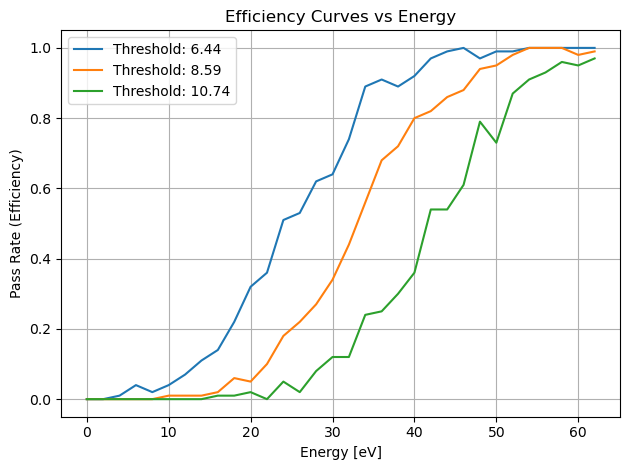

In [7]:
# Thresholds
threshold_base = 2.1476
thresholds = [threshold_base * n for n in [3, 4, 5]]

# Path to QP sample files
base_path = Path("/ceph/dwong/trigger_samples/qp_sample")
file_paths = sorted(base_path.glob("QP_sample_quantized_*eV.zst"))

# Extract and sort energies numerically
def extract_energy(fp):
    match = re.search(r'_(\d+)eV', fp.stem)
    return int(match.group(1)) if match else -1

file_paths = sorted(file_paths, key=extract_energy)
energies = [extract_energy(fp) for fp in file_paths]

# Store efficiency results
efficiency_results = {thr: [] for thr in thresholds}

# Process each energy level
for energy, path in zip(energies, file_paths):
    quantized_trace = load_traces_from_zstd(str(path), n_traces=100)  # shape (100, 54, 32768)
    
    amplitudes = []
    for trace_set in quantized_trace:
        sum_trace = np.sum(trace_set[45:], axis=0)
        amp = sum_of.fit(sum_trace)
        amplitudes.append(amp)
    
    amplitudes = np.array(amplitudes)
    
    for thr in thresholds:
        pass_rate = np.sum(amplitudes > thr) / len(amplitudes)
        efficiency_results[thr].append(pass_rate)

# Plot efficiency curves
plt.figure()
for thr in thresholds:
    plt.plot(energies, efficiency_results[thr], label=f"Threshold: {thr:.2f}")
plt.xlabel("Energy [eV]")
plt.ylabel("Pass Rate (Efficiency)")
plt.title("Efficiency Curves vs Energy")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

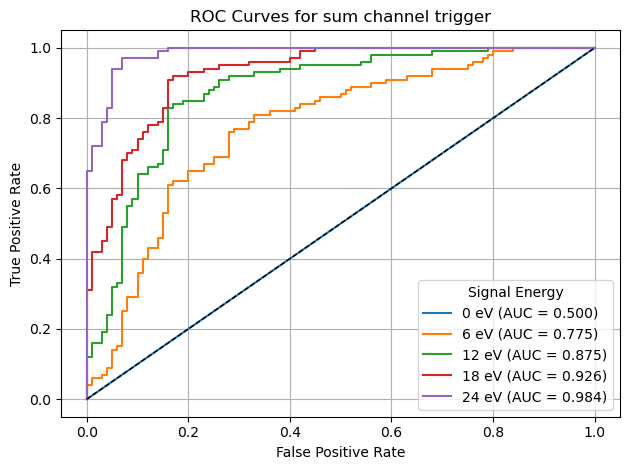

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from pathlib import Path
import re

# Define path and load files
base_path = Path("/ceph/dwong/trigger_samples/qp_sample")
file_paths = sorted(base_path.glob("QP_sample_quantized_*eV.zst"))

# Extract and sort by energy
def extract_energy(fp):
    match = re.search(r'_(\d+)eV', fp.stem)
    return int(match.group(1)) if match else -1

file_paths = sorted(file_paths, key=extract_energy)
energies = [extract_energy(fp) for fp in file_paths]

# Prepare dictionary of energy -> amplitudes
energy_to_amplitudes = {}

for energy, path in zip(energies, file_paths):
    if energy not in {0, 6, 12, 18, 24}:
        continue

    traces = load_traces_from_zstd(str(path), n_traces=100)  # shape: (100, 54, 32768)
    amps = []

    for trace_set in traces:
        sum_trace = np.sum(trace_set[45:], axis=0)
        amp = sum_of.fit(sum_trace)

        if isinstance(amp, (list, tuple, np.ndarray)):
            amp = amp[0]  # extract scalar
        amps.append(amp)

    energy_to_amplitudes[energy] = np.array(amps)

# Compute and plot ROC for each energy vs 0 eV
plt.figure()

for signal_energy in [0, 6, 12, 18, 24]:
    signal_amps = energy_to_amplitudes[signal_energy]
    background_amps = energy_to_amplitudes[0]

    amplitudes = np.concatenate([background_amps, signal_amps])
    labels = np.concatenate([
        np.zeros(len(background_amps)),  # 0 = noise
        np.ones(len(signal_amps))        # 1 = signal
    ])

    fpr, tpr, _ = roc_curve(labels, amplitudes)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{signal_energy} eV (AUC = {roc_auc:.3f})")

# Plot formatting
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for sum channel trigger")
plt.grid(True)
plt.legend(title="Signal Energy")
plt.tight_layout()
plt.show()
